In [98]:
# Import dependencies
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import pandas as pd
import numpy as np
import requests
from prophet import Prophet
import seaborn as sns
import os
from dotenv import load_dotenv


In [ ]:
# Load environment variables from .env file
load_dotenv()
zillow_api_key = os.getenv('ZILLOW_API_KEY')

# Zillo API URL
#url = "https://api.bridgedataoutput.com/api/v2/zgecon/"

# Build URL
#query_url = f"{url}{type}access_code={zillow_api_key}&metadataType="

In [ ]:
# Zillow API endpoint
zillow_endpoint = "https://www.zillow.com/webservice/GetSearchResults.htm"

In [ ]:
# Function to fetch data from Zillow API
def get_zillow_data(address, citystatezip):
    params = {
        'zws-id': zillow_api_key,
        'address': address,
        'citystatezip': citystatezip
    }
    response = requests.get(zillow_endpoint, params=params)
    data = response.json()
    return data

In [ ]:
# Function to parse Zillow data
def parse_zillow_data(data):
    try:
        zestimate = data['response']['results']['result']['zestimate']['amount']['#text']
        return float(zestimate)
    except KeyError:
        return None

In [ ]:
# Function to add Zillow data to Ames Housing DataFrame
def add_zillow_data(df):
    zillow_estimates = []
    for idx, row in df.iterrows():
        address = f"{row['Street']} {row['City']} {row['State']} {row['Zip']}"
        citystatezip = f"{row['City']} {row['State']} {row['Zip']}"
        zillow_data = get_zillow_data(address, citystatezip)
        zestimate = parse_zillow_data(zillow_data)
        zillow_estimates.append(zestimate)
    df['Zestimate'] = zillow_estimates
    return df

### Data Preprocessing


In [99]:
# Fetch the data
ames_df = pd.read_csv('Resources/ames_housing.csv')

In [100]:
# CHecking the data types
ames_df.dtypes

Order               int64
PID                 int64
MS SubClass         int64
MS Zoning          object
Lot Frontage      float64
                   ...   
Mo Sold             int64
Yr Sold             int64
Sale Type          object
Sale Condition     object
SalePrice           int64
Length: 82, dtype: object

In [101]:
# Display the data
ames_df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [102]:
# Check for missing values
missing_values = ames_df.isnull().sum()

print(missing_values[missing_values > 0])

Lot Frontage       490
Alley             2732
Mas Vnr Type      1775
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin SF 1         1
BsmtFin Type 2      81
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual        159
Garage Cond        159
Pool QC           2917
Fence             2358
Misc Feature      2824
dtype: int64


In [103]:
# Calculate the percentage of missing values
percent_missing = missing_values / len(ames_df) * 100

print(percent_missing[percent_missing > 0])

Lot Frontage      16.723549
Alley             93.242321
Mas Vnr Type      60.580205
Mas Vnr Area       0.784983
Bsmt Qual          2.730375
Bsmt Cond          2.730375
Bsmt Exposure      2.832765
BsmtFin Type 1     2.730375
BsmtFin SF 1       0.034130
BsmtFin Type 2     2.764505
BsmtFin SF 2       0.034130
Bsmt Unf SF        0.034130
Total Bsmt SF      0.034130
Electrical         0.034130
Bsmt Full Bath     0.068259
Bsmt Half Bath     0.068259
Fireplace Qu      48.532423
Garage Type        5.358362
Garage Yr Blt      5.426621
Garage Finish      5.426621
Garage Cars        0.034130
Garage Area        0.034130
Garage Qual        5.426621
Garage Cond        5.426621
Pool QC           99.556314
Fence             80.477816
Misc Feature      96.382253
dtype: float64


In [104]:
# Impute missing values for numerical features using the mean
# numerical_columns = ames_df.select_dtypes(include=['int64', 'float64']).columns

# for column in numerical_columns:
#     ames_df[column].fillna(ames_df[column].mean(), inplace=True)

In [105]:
# Impute missing values for categorical features using the mode
# categorical_columns = ames_df.select_dtypes(include=['object']).columns

# for column in categorical_columns:
#     ames_df[column].fillna(ames_df[column].mode()[0], inplace=True)

In [106]:
# Verify that there are no missing values
missing_values = ames_df.isnull().sum()

missing_values

Order               0
PID                 0
MS SubClass         0
MS Zoning           0
Lot Frontage      490
                 ... 
Mo Sold             0
Yr Sold             0
Sale Type           0
Sale Condition      0
SalePrice           0
Length: 82, dtype: int64

In [107]:
# Show the updated dataframe's top 5 rows
ames_df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [ ]:
# Show the updated dataframes last 5 rows
ames_df.tail()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000
2929,2930,924151050,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,188000


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000
2929,2930,924151050,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,188000


### Feature Engineering

In [ ]:
# Creating new features
ames_df['TotalSF'] = ames_df['1st Flr SF'] + ames_df['2nd Flr SF'] + ames_df['Total Bsmt SF']
ames_df['Age'] = ames_df['Yr Sold'] - ames_df['Year Built']
#ames_df['Remodeled'] = (ames_df['Year Built'] != ames_df['Year Remod/Add']).astype(int)

In [ ]:
# Drop the original features
ames_df = ames_df.drop(['1st Flr SF', '2nd Flr SF', 'Total Bsmt SF', 'Yr Sold', 'Year Built', 'Year Remod/Add'], axis=1)

In [ ]:
# Selecting columns
ames_df = ames_df[['TotalSF','Age', 'Overall Qual', 'Garage Area', 'Gr Liv Area', 'Lot Area', 'SalePrice']]

In [ ]:
# Impute missing values for numerical features using the mean
numerical_columns = ames_df.select_dtypes(include=['int64', 'float64']).columns

for column in numerical_columns:
    ames_df[column].fillna(ames_df[column].mean(), inplace=True)

### Label Encoding & One-Hot Encoding

In [ ]:
# Encode categorical features
binary_columns = [column for column in ames_df.columns if ames_df[column].nunique() == 2]

label_encoders = {}

for column in binary_columns:
    label_encoders[column] = LabelEncoder()
    ames_df[column] = label_encoders[column].fit_transform(ames_df[column])

In [ ]:
# # One-hot encode the remaining categorical features
# ames_df = pd.get_dummies(ames_df, columns=[column for column in categorical_columns if column not in binary_columns])

In [ ]:
# Summary statistics
summary = ames_df.describe()

summary

,TotalSF,Age,Overall Qual,Garage Area,Gr Liv Area,Lot Area,SalePrice
count,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,2546.832707,36.434130,6.094881,472.819734,1499.690444,10147.921843,180796.060068
std,803.772450,30.291357,1.411026,215.009836,505.508887,7880.017759,79886.692357
min,334.000000,-1.000000,1.000000,0.000000,334.000000,1300.000000,12789.000000
25%,2000.500000,7.000000,5.000000,320.000000,1126.000000,7440.250000,129500.000000
50%,2452.000000,34.000000,6.000000,480.000000,1442.000000,9436.500000,160000.000000
75%,2990.000000,54.000000,7.000000,576.000000,1742.750000,11555.250000,213500.000000
max,11752.000000,136.000000,10.000000,1488.000000,5642.000000,215245.000000,755000.000000


### Visualizations  

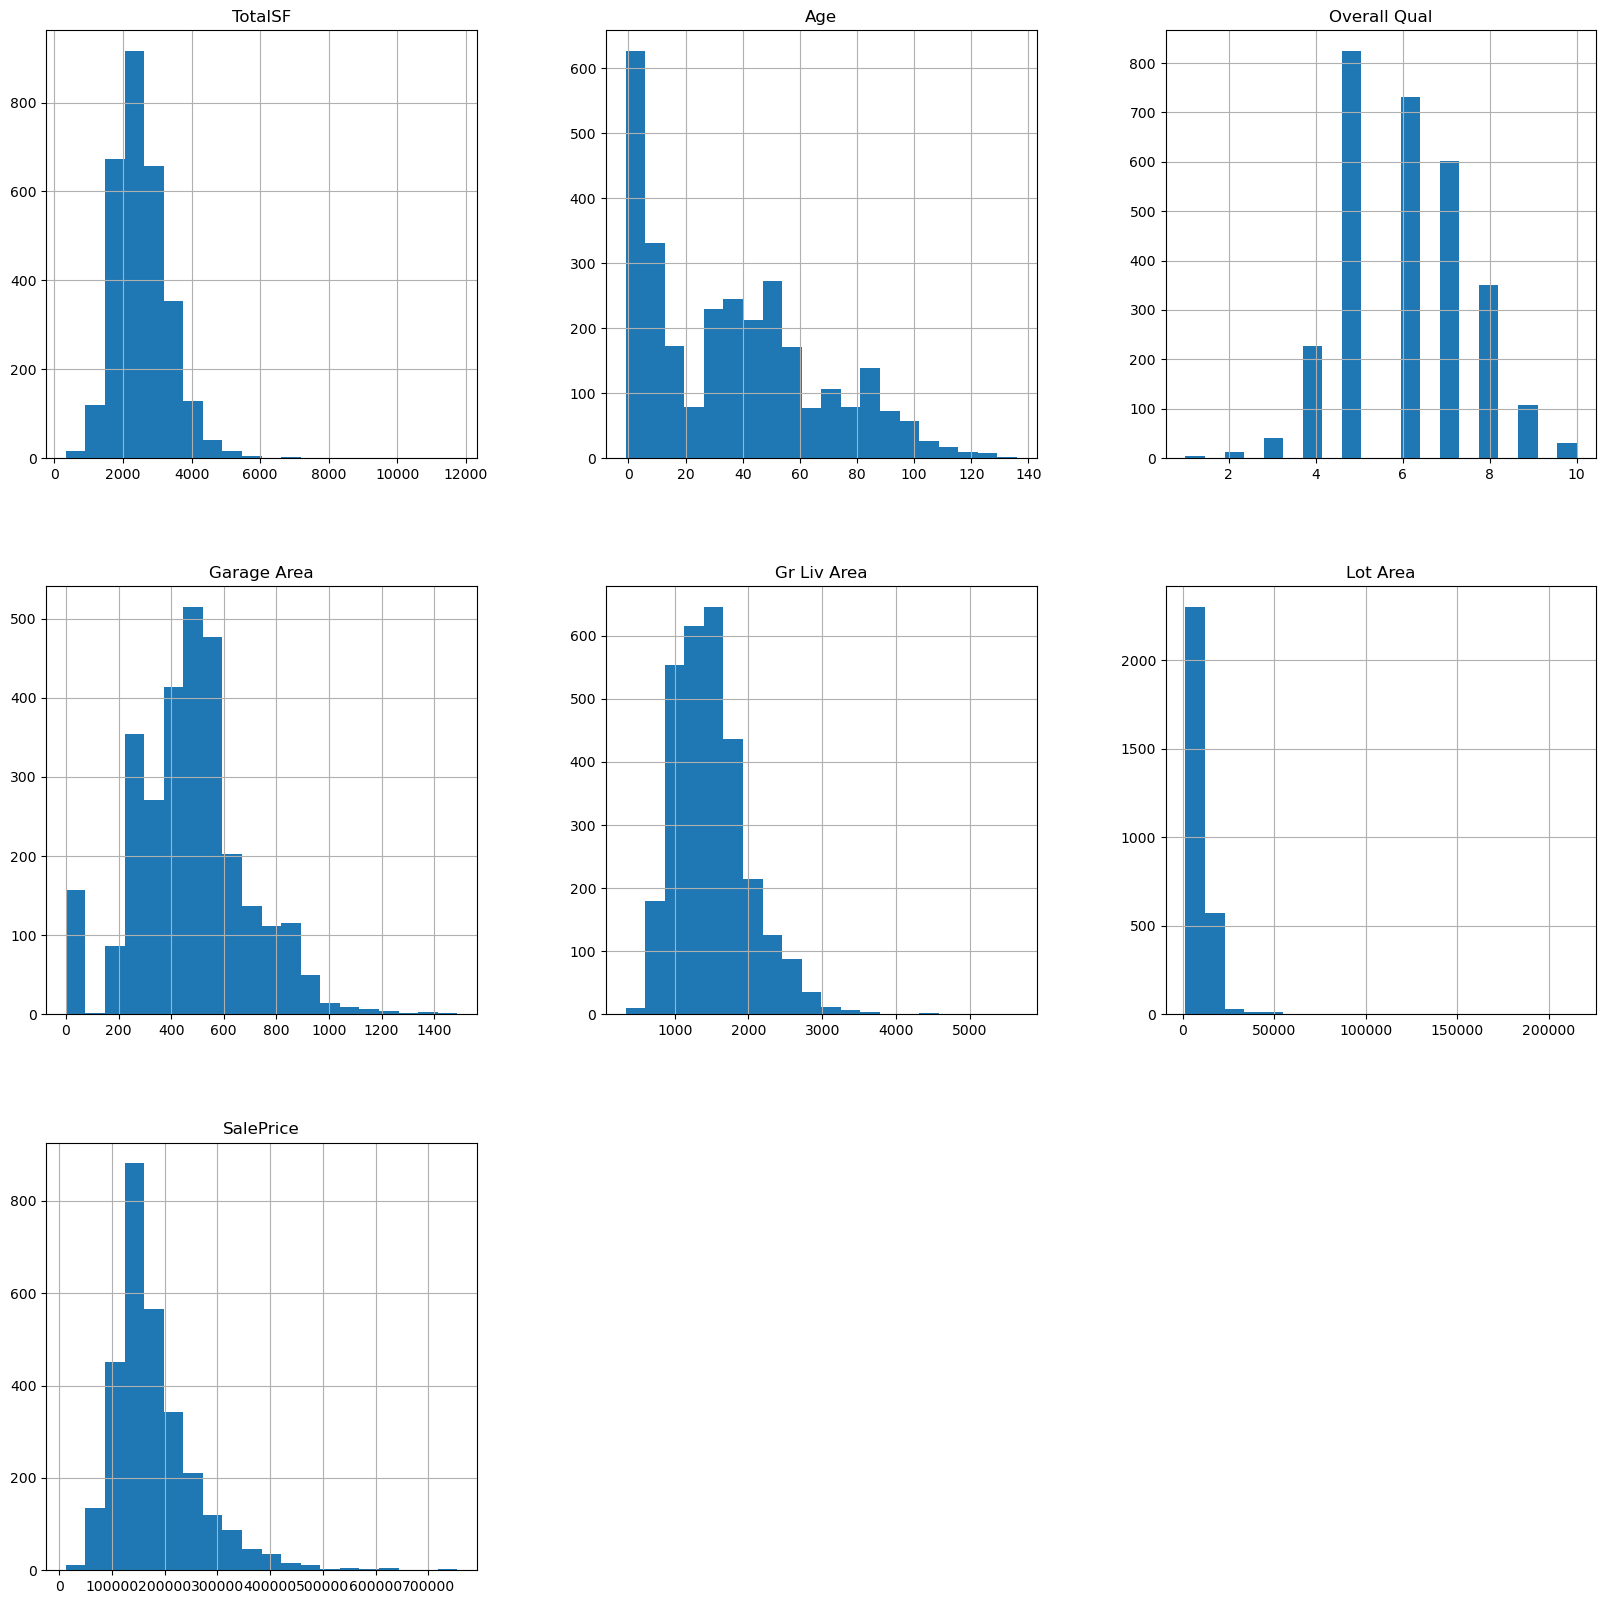

In [ ]:
# Histogram for numerical features 
ames_df[numerical_columns].hist(bins=20, figsize=(20,20))
plt.show()

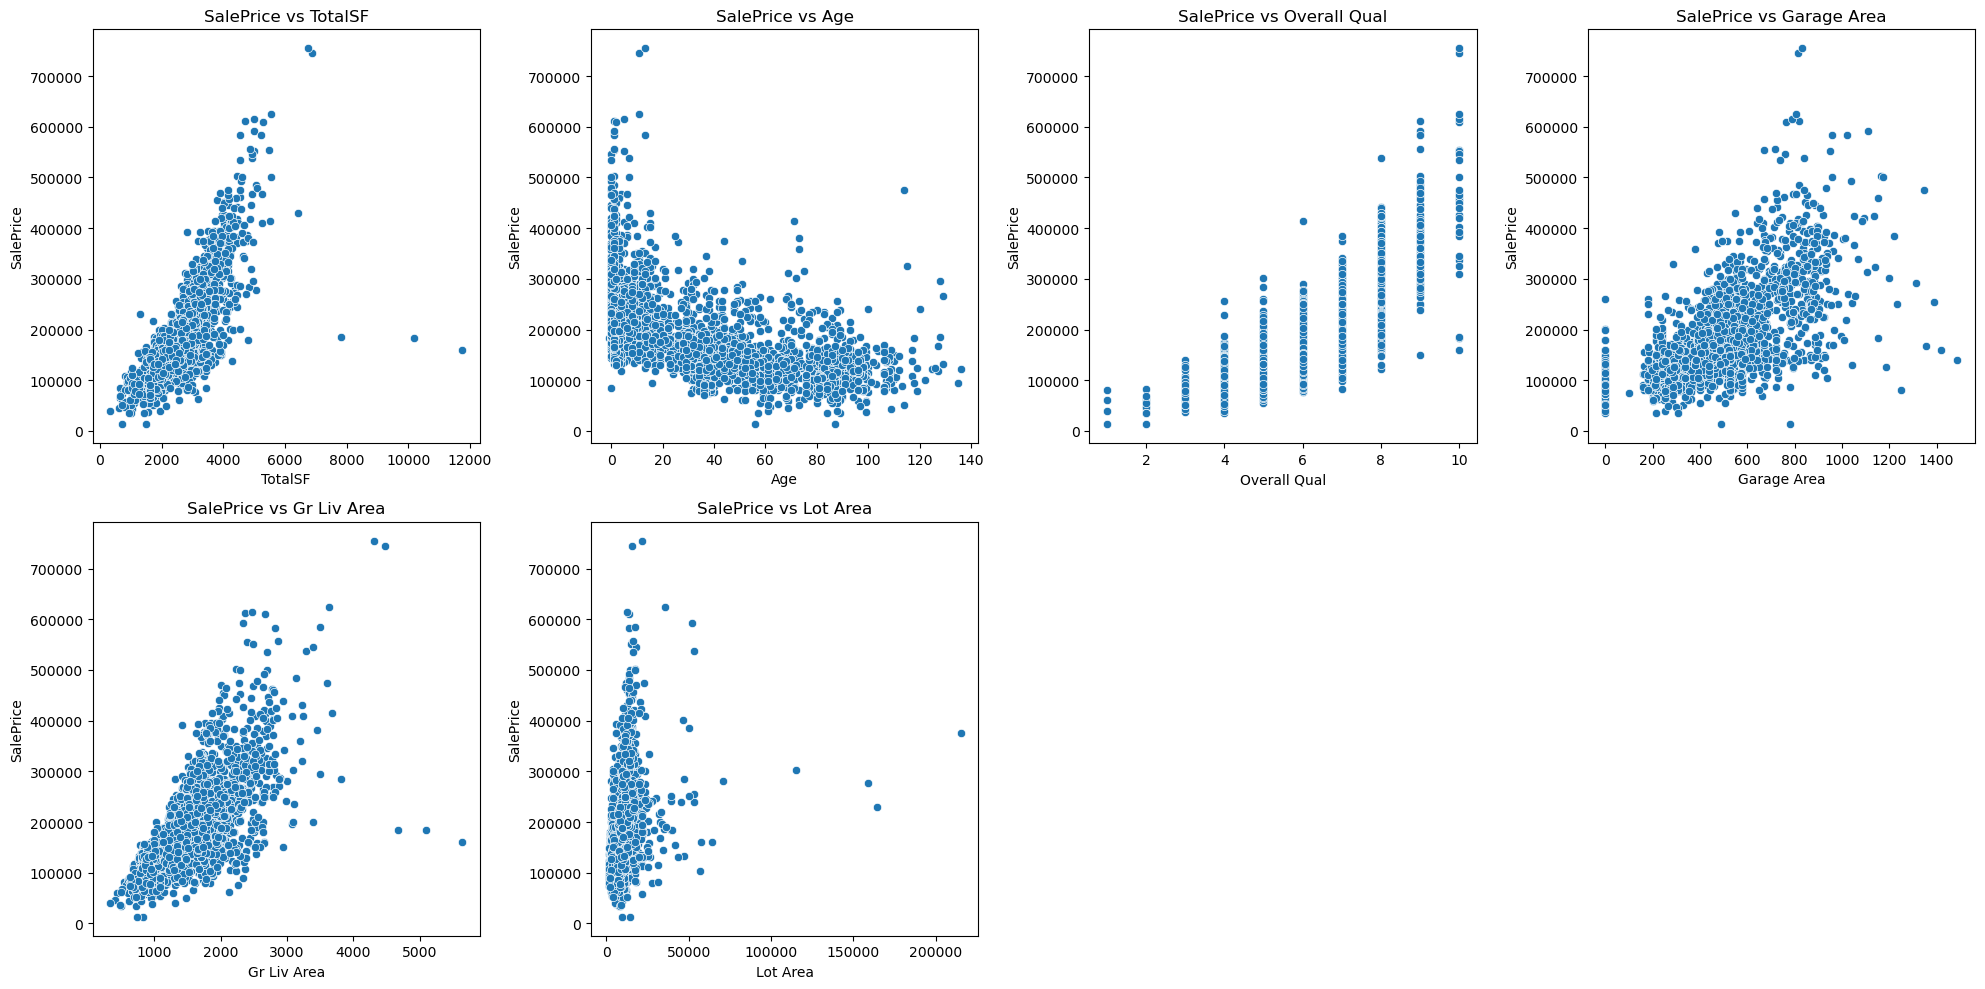

In [ ]:
# Scatter plots for numerical features against SalePrice
num_plots = len(numerical_columns) - 1  
cols = 4  
rows = (num_plots // cols) + 1

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 5))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    if col != 'SalePrice':
        sns.scatterplot(x=ames_df[col], y=ames_df['SalePrice'], ax=axes[i])
        axes[i].set_title(f'SalePrice vs {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('SalePrice')

# Remove any empty subplots
for j in range(i, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

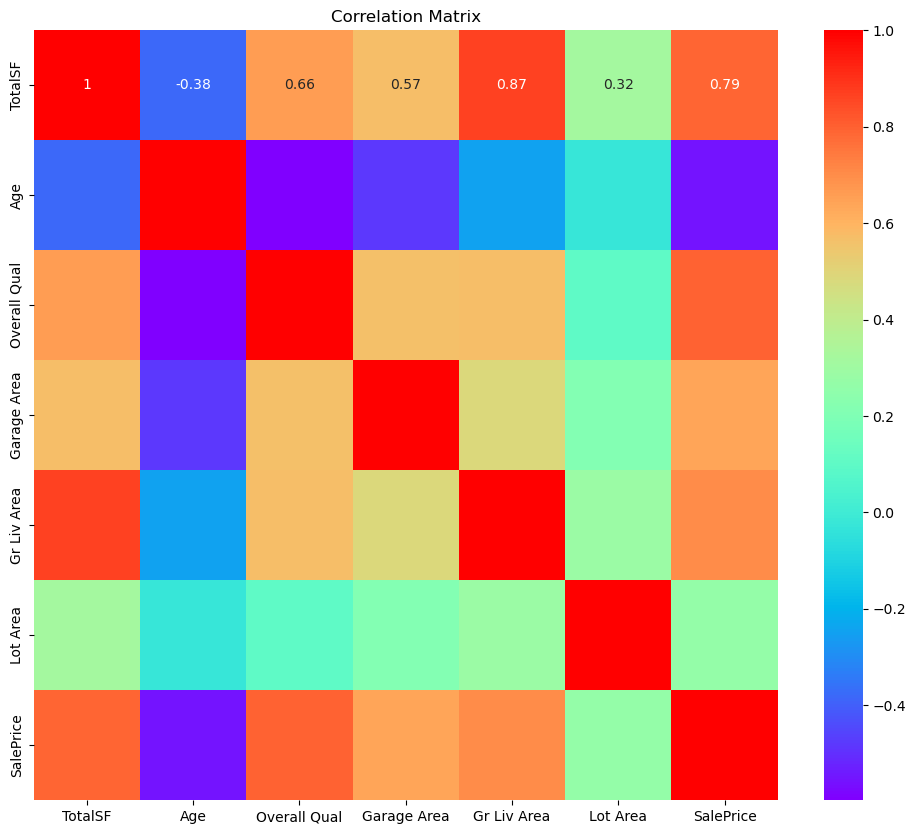

In [ ]:
# Heatmap for correlations
plt.figure(figsize=(12, 10))
sns.heatmap(ames_df.corr(), annot=True, cmap='rainbow')
plt.title('Correlation Matrix')
plt.show()

### Handling Outliers

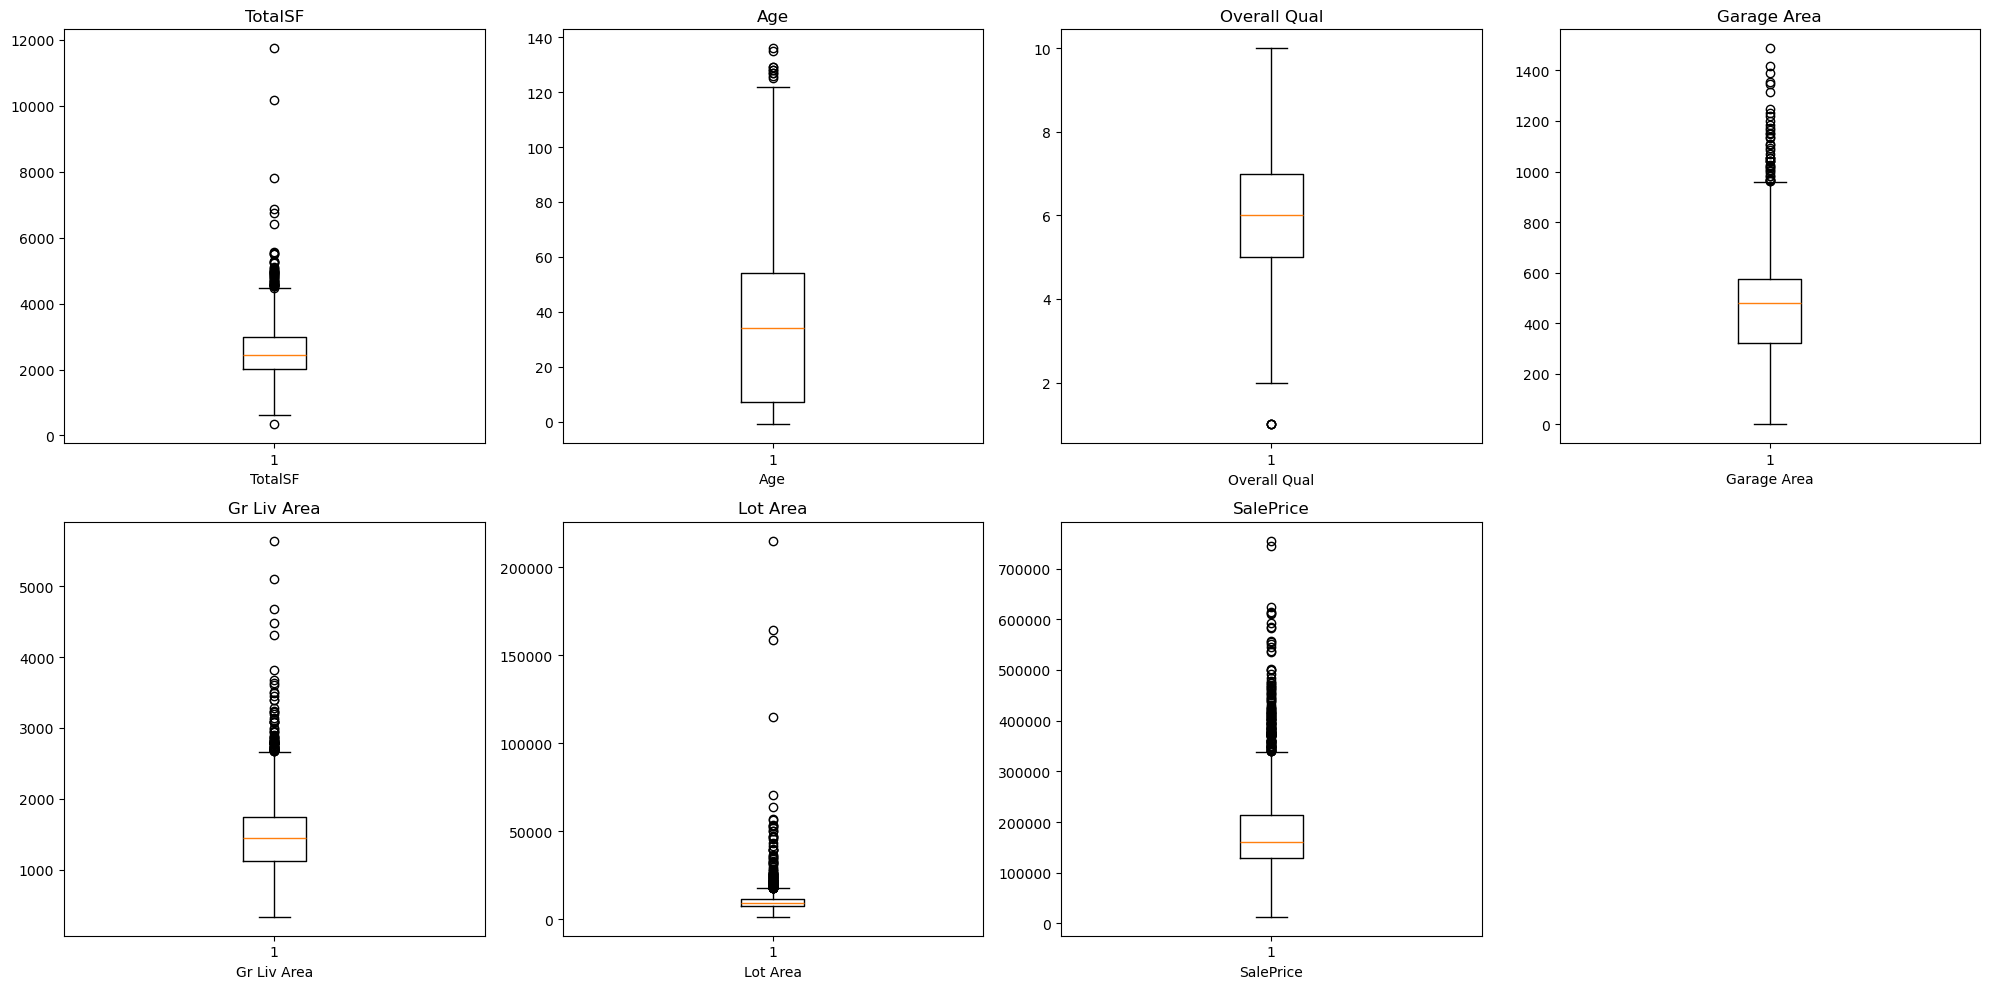

In [ ]:
#Create box plots for numerical columns to help identify outliers
num_plots = len(numerical_columns) - 1  
cols = 4  
rows = (num_plots // cols) + 1

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 5))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    
    axes[i].boxplot(ames_df[col].values)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Model Training and Evaluation

In [ ]:
# Create Feature and Target Variable arrays
X = ames_df.drop(columns=['SalePrice'])
y = ames_df['SalePrice']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [ ]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# create a dictionary to store the data split data to make it easier to pass to functions
data = [X_train_scaled, X_test_scaled, y_train, y_test]

In [ ]:
# Create function to evaluate models
def evaluate_model(model, data):
    """
    This function evaluates the performance of a model on the training and testing data.
    
    Args:
    model: the model to evaluate
    data: a list containing the scaled training and testing data
    
    
    Returns:
    train_score, test_score, mse, mae, r2,top_features, y_pred
    """
    X_train_scaled, X_test_scaled, y_train, y_test = data
    
    reg = model.fit(X_train_scaled, y_train)
    
    print(f'Evaluating {model.__class__.__name__} model...')
    train_score = reg.score(X_train_scaled, y_train)
    test_score = reg.score(X_test_scaled, y_test)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    top_features = "Not applicable for this model"
    
     
    
    # Feature Importance for Tree-based models
    has_feature_importances = hasattr(model, 'feature_importances_')
    
    if has_feature_importances==True:
        # Get the feature importances
        feat_importances = model.feature_importances_

        # Get number of features
        num_features = len(X_test_scaled)

        # Get the feature names
        feat_names = X.columns

        # Sort the feature importances and names in descending order
        sorted_importances = sorted(zip(feat_importances, feat_names), reverse=True)

        # Select number of features to display
        if num_features >= 15:
            num_features_to_keep = 15
        elif 10 <= num_features < 15:
            num_features_to_keep = 10
        elif 5 <= num_features < 10:
             num_features_to_keep = 5
        else:
            num_features_to_keep = num_features
        
        
        # Select the top features
        top_features = sorted_importances[:num_features_to_keep]

        
    return train_score, test_score, mse, mae, r2,top_features, y_pred


In [ ]:
def grid_tuned_model(model, param_grid, data):
    """
    This function performs a grid search to find the best hyperparameters for a model.
    
    Args:
    model: the model to tune
    param_grid: a dictionary containing the hyperparameters to tune
    data: a list containing the scaled training and testing data
    
    Returns:
    train_score, test_score, mse, mae, r2, top_5_features,y_pred
    """
    print(f'Tuning {type(model).__name__} model...')
    grid_search = GridSearchCV(model, param_grid, n_jobs=-1, verbose=1, return_train_score=True)
    grid_search.fit(X_train_scaled, y_train)
    
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}')
    
    
    # Train and evaluate a new model with the best hyperparameters
    best_model = grid_search.best_estimator_
    print(f'Training tuned {model.__class__.__name__} model...')
    train_score, test_score, mse, mae, r2, top_5_features,y_pred = evaluate_model(best_model, data)
    return train_score, test_score, mse, mae, r2, top_5_features,y_pred
    

In [ ]:
# Print X_train_scaled
print(X_train_scaled)

[[-0.09503462 -0.14113838  0.67394069  0.04671444 -0.24352173  0.03380992]
 [ 0.75646316  0.15509635 -0.76674967  0.3245679   1.25495594  2.30708197]
 [-1.64503646  0.25384126 -1.48709485 -0.03334503 -0.53291028 -0.03551382]
 ...
 [ 0.07049956 -1.06275755 -0.04640449  0.96033427  0.46607484 -0.16608596]
 [ 0.17583949  1.66918498 -0.76674967 -1.14946821  0.4898602  -0.35032808]
 [-1.25377386 -0.0094785  -0.76674967 -0.34416414 -1.43675395 -0.36374558]]


In [ ]:
# Evaluate models by calling evaluate_model function

# Create an empty list to store the results
results = []
# Set random state to produce reproducible results
rs = 42
# Create a list of models to evaluate
models = [LinearRegression(), 
          DecisionTreeRegressor(random_state=rs), 
          RandomForestRegressor(random_state=rs), 
          GradientBoostingRegressor(random_state=rs)
          ]
# Create a list of hyperparameter grids for tuning
model_param_grid = [
    {
        'fit_intercept': [True, False],
        'positive': [True, False]
     },
     {
        'max_depth': np.arange(1,10),
        'min_samples_split': np.arange(2,10),
        'min_samples_leaf': np.arange(1,10)
      },
      {
        'n_estimators': np.arange(50,1001,50)
       },
       {
        'n_estimators': np.arange(50,1001,50)
        }
        ]

# Evaluate the models
for model in models:
    print(f'Training {model.__class__.__name__} model...')
    train_score, test_score, mse, mae, r2, top_features,y_pred = evaluate_model(model, data)
    result = {'Model': type(model).__name__, 
              'Train Score': round(train_score,3), 
              'Test Score': format(test_score, '.3f'), 
              'MSE': format(mse, '.3f'), 
              'MAE': format(mae,'.3f'), 
              'R2': format(r2,'.3f'),
              'Top Features': top_features,
              'Predicted Values': y_pred,
              
              }

    results.append(result)

    train_score, test_score, mse, mae, r2, top_features,y_pred = grid_tuned_model(model, model_param_grid[models.index(model)], data)
    result = {'Model': f'{type(model).__name__} (Tuned)', 
              'Train Score': round(train_score,3), 
              'Test Score': format(test_score, '.3f'), 
              'MSE': format(mse, '.3f'), 
              'MAE': format(mae,'.3f'), 
              'R2': format(r2,'.3f'),
              'Top Features': top_features,
              'Predicted Values': y_pred,
              
              }

    results.append(result)
    print(f'{model.__class__.__name__} model evaluation complete.\n')
results_df = pd.DataFrame(results)

Training LinearRegression model...
Evaluating LinearRegression model...
Tuning LinearRegression model...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'fit_intercept': True, 'positive': False}
Best score: 0.7814908295097404
Training tuned LinearRegression model...
Evaluating LinearRegression model...
LinearRegression model evaluation complete.

Training DecisionTreeRegressor model...
Evaluating DecisionTreeRegressor model...
Tuning DecisionTreeRegressor model...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 9}
Best score: 0.8164414576787561
Training tuned DecisionTreeRegressor model...
Evaluating DecisionTreeRegressor model...
DecisionTreeRegressor model evaluation complete.

Training RandomForestRegressor model...
Evaluating RandomForestRegressor model...
Tuning RandomForestRegressor model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [ ]:
# Show results_df
results_df.head(10)

,Model,Train Score,Test Score,MSE,MAE,R2,Top Features,Predicted Values
0,LinearRegression,0.789,0.803,1583096593.894,25002.181,0.803,Not applicable for this model,"[187536.00612379218, 128051.5882557808, 220816..."
1,LinearRegression (Tuned),0.789,0.803,1583096593.894,25002.181,0.803,Not applicable for this model,"[187536.00612379218, 128051.5882557808, 220816..."
2,DecisionTreeRegressor,1.000,0.757,1950634408.889,26676.053,0.757,"[(0.5239780146313097, Overall Qual), (0.304986...","[182000.0, 108000.0, 196500.0, 132000.0, 11900..."
3,DecisionTreeRegressor (Tuned),0.896,0.807,1547925389.544,22935.049,0.807,"[(0.581715302261622, Overall Qual), (0.3184724...","[183021.73913043478, 105657.41414141415, 20258..."
4,RandomForestRegressor,0.979,0.879,973891586.400,18125.666,0.879,"[(0.49339995713828033, Overall Qual), (0.34226...","[175585.0, 104779.66333333332, 198113.04, 1228..."
5,RandomForestRegressor (Tuned),0.981,0.875,1005886723.053,18247.911,0.875,"[(0.5098262709110313, Overall Qual), (0.326617...","[184647.568, 103500.68298412696, 199181.524, 1..."
6,GradientBoostingRegressor,0.929,0.890,880869704.963,18320.882,0.890,"[(0.4424683916223564, Overall Qual), (0.406988...","[180038.32805481498, 106649.90554448347, 20288..."
7,GradientBoostingRegressor (Tuned),0.929,0.890,880869704.963,18320.882,0.890,"[(0.4424683916223564, Overall Qual), (0.406988...","[180038.32805481498, 106649.90554448347, 20288..."


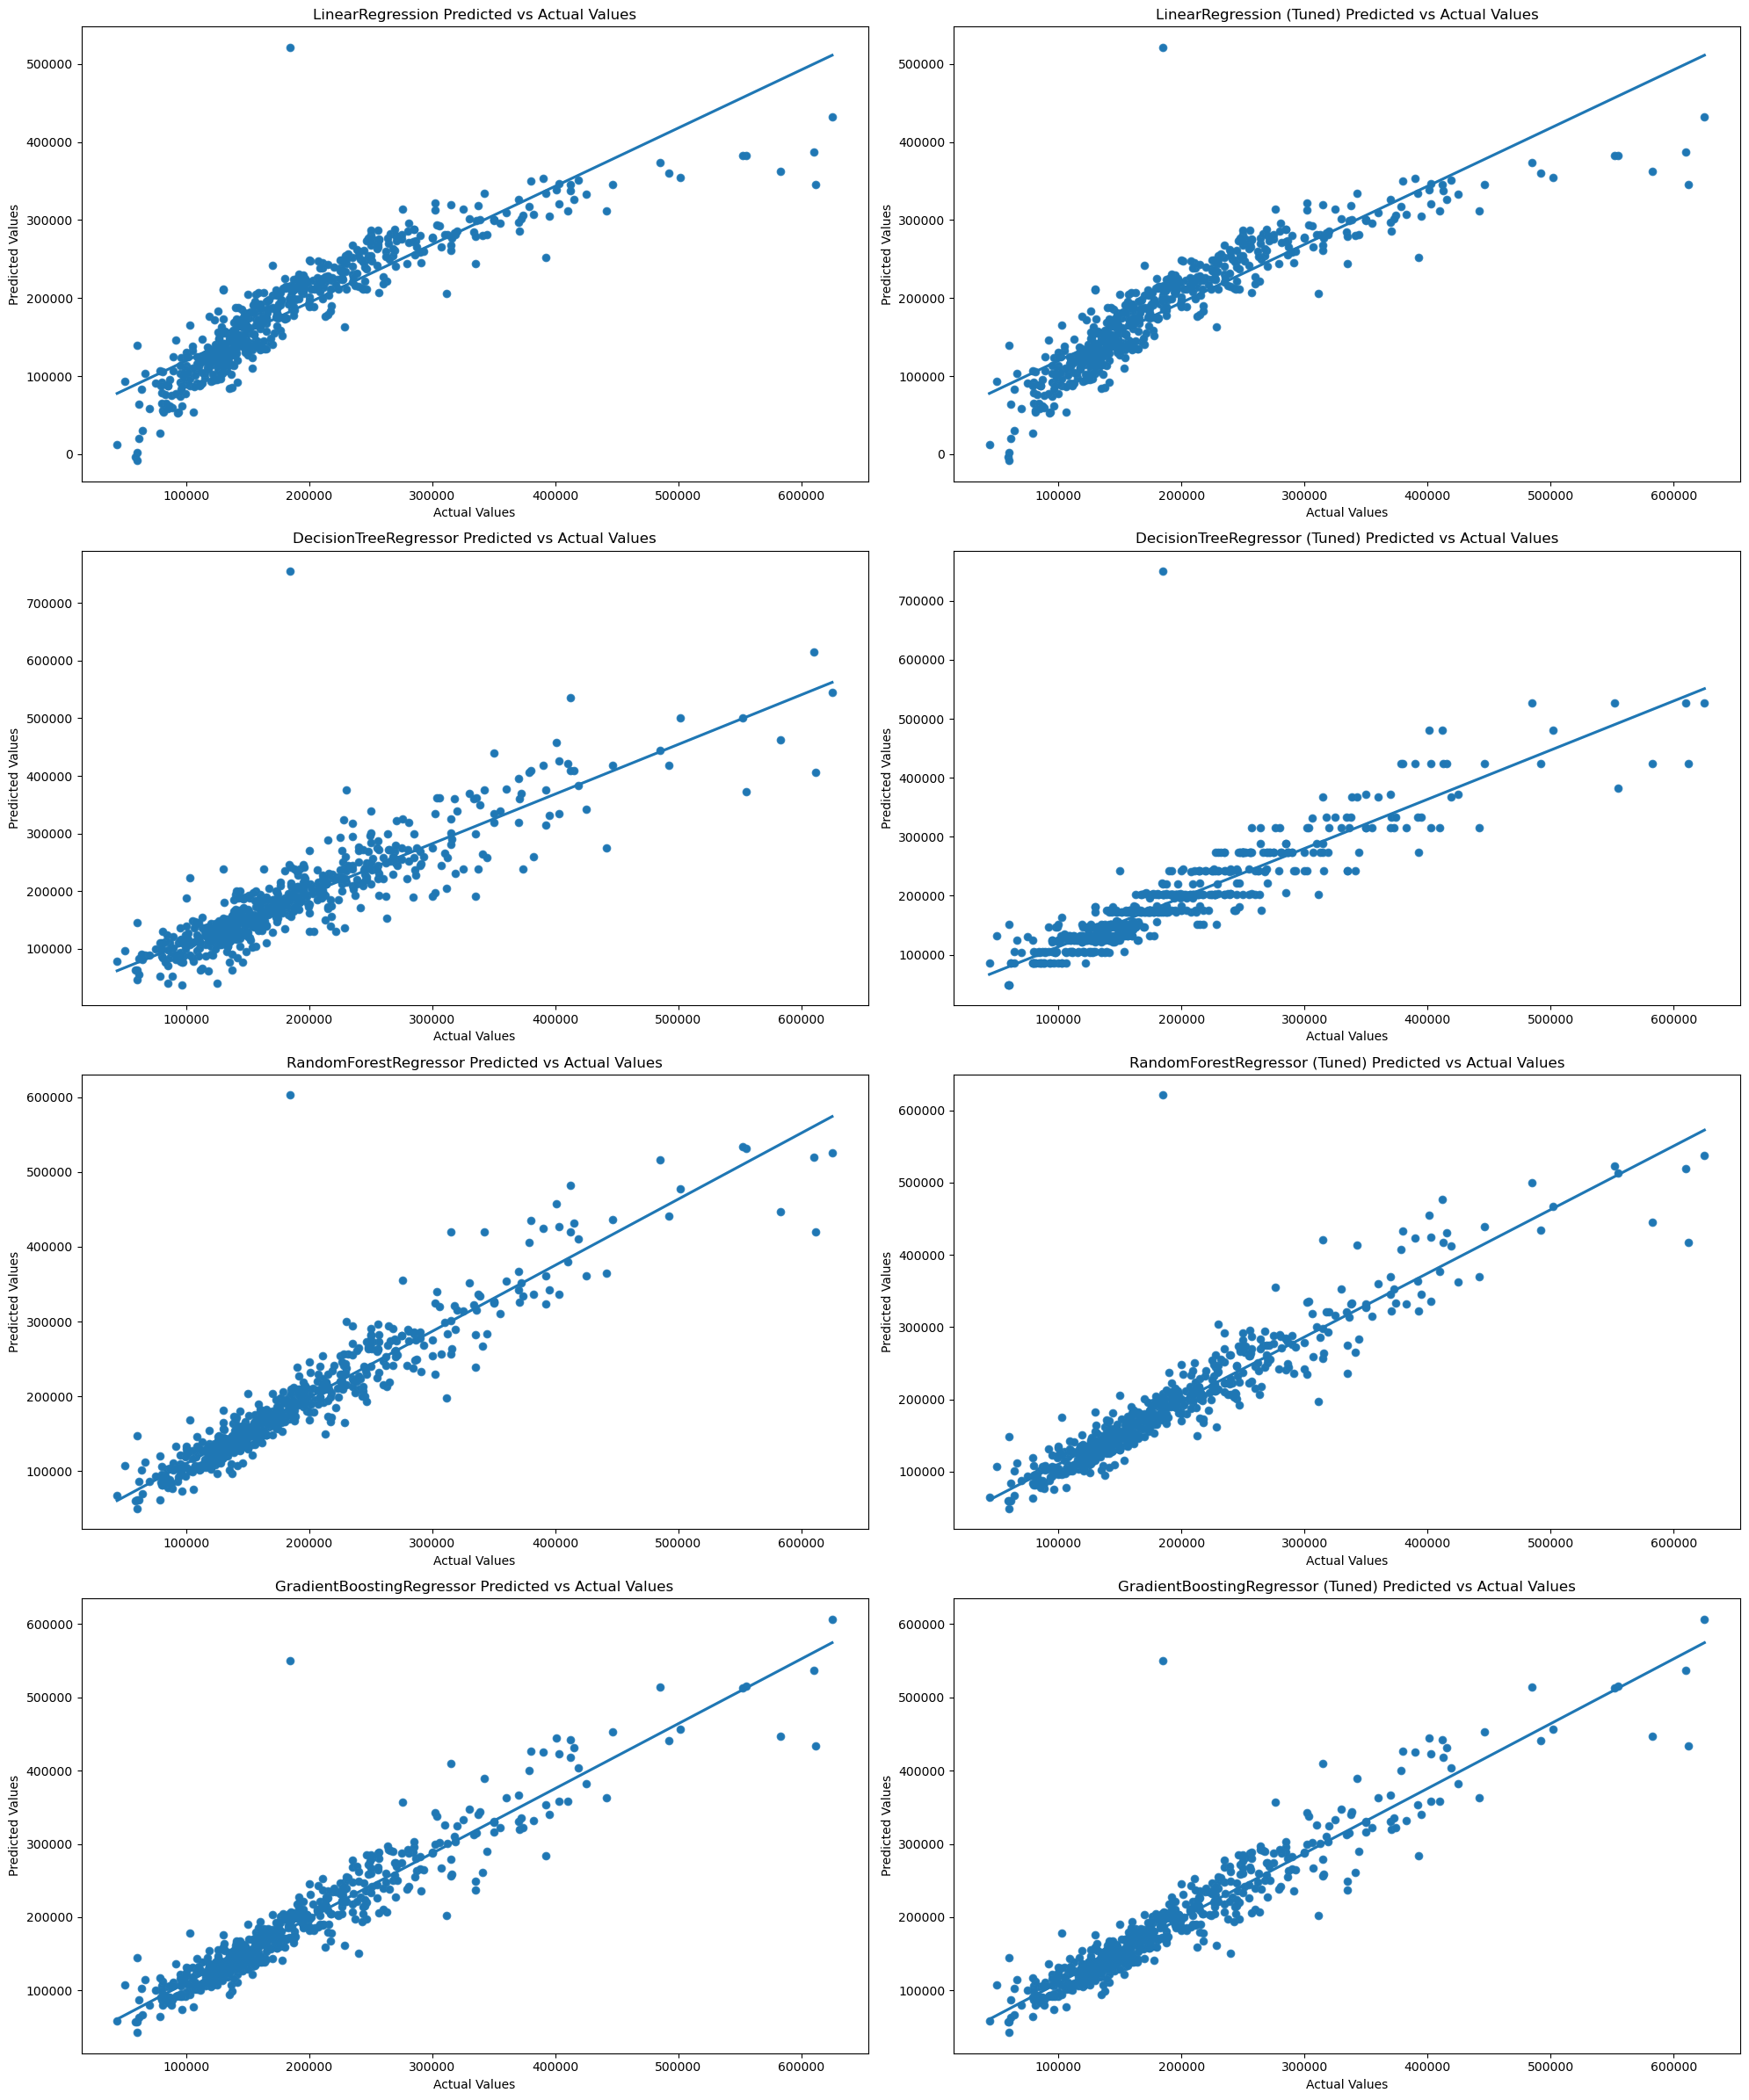

In [ ]:
# Plot the predicted valudes vs actual values for each model
rows = len(results_df) // 2 
fig, axs = plt.subplots(rows, 2, figsize=(20, rows * 6))
for i, model in enumerate(results_df['Model']):
    y_pred = results_df.loc[i, 'Predicted Values']
    ax = axs[i // 2, i % 2]
    ax = sns.scatterplot(x=y_test, y=y_pred, ax=ax)
    ax = sns.regplot(x=y_test, y=y_pred, ax=ax, ci=None)
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'{results_df.loc[i, "Model"]} Predicted vs Actual Values')

# Remove any empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

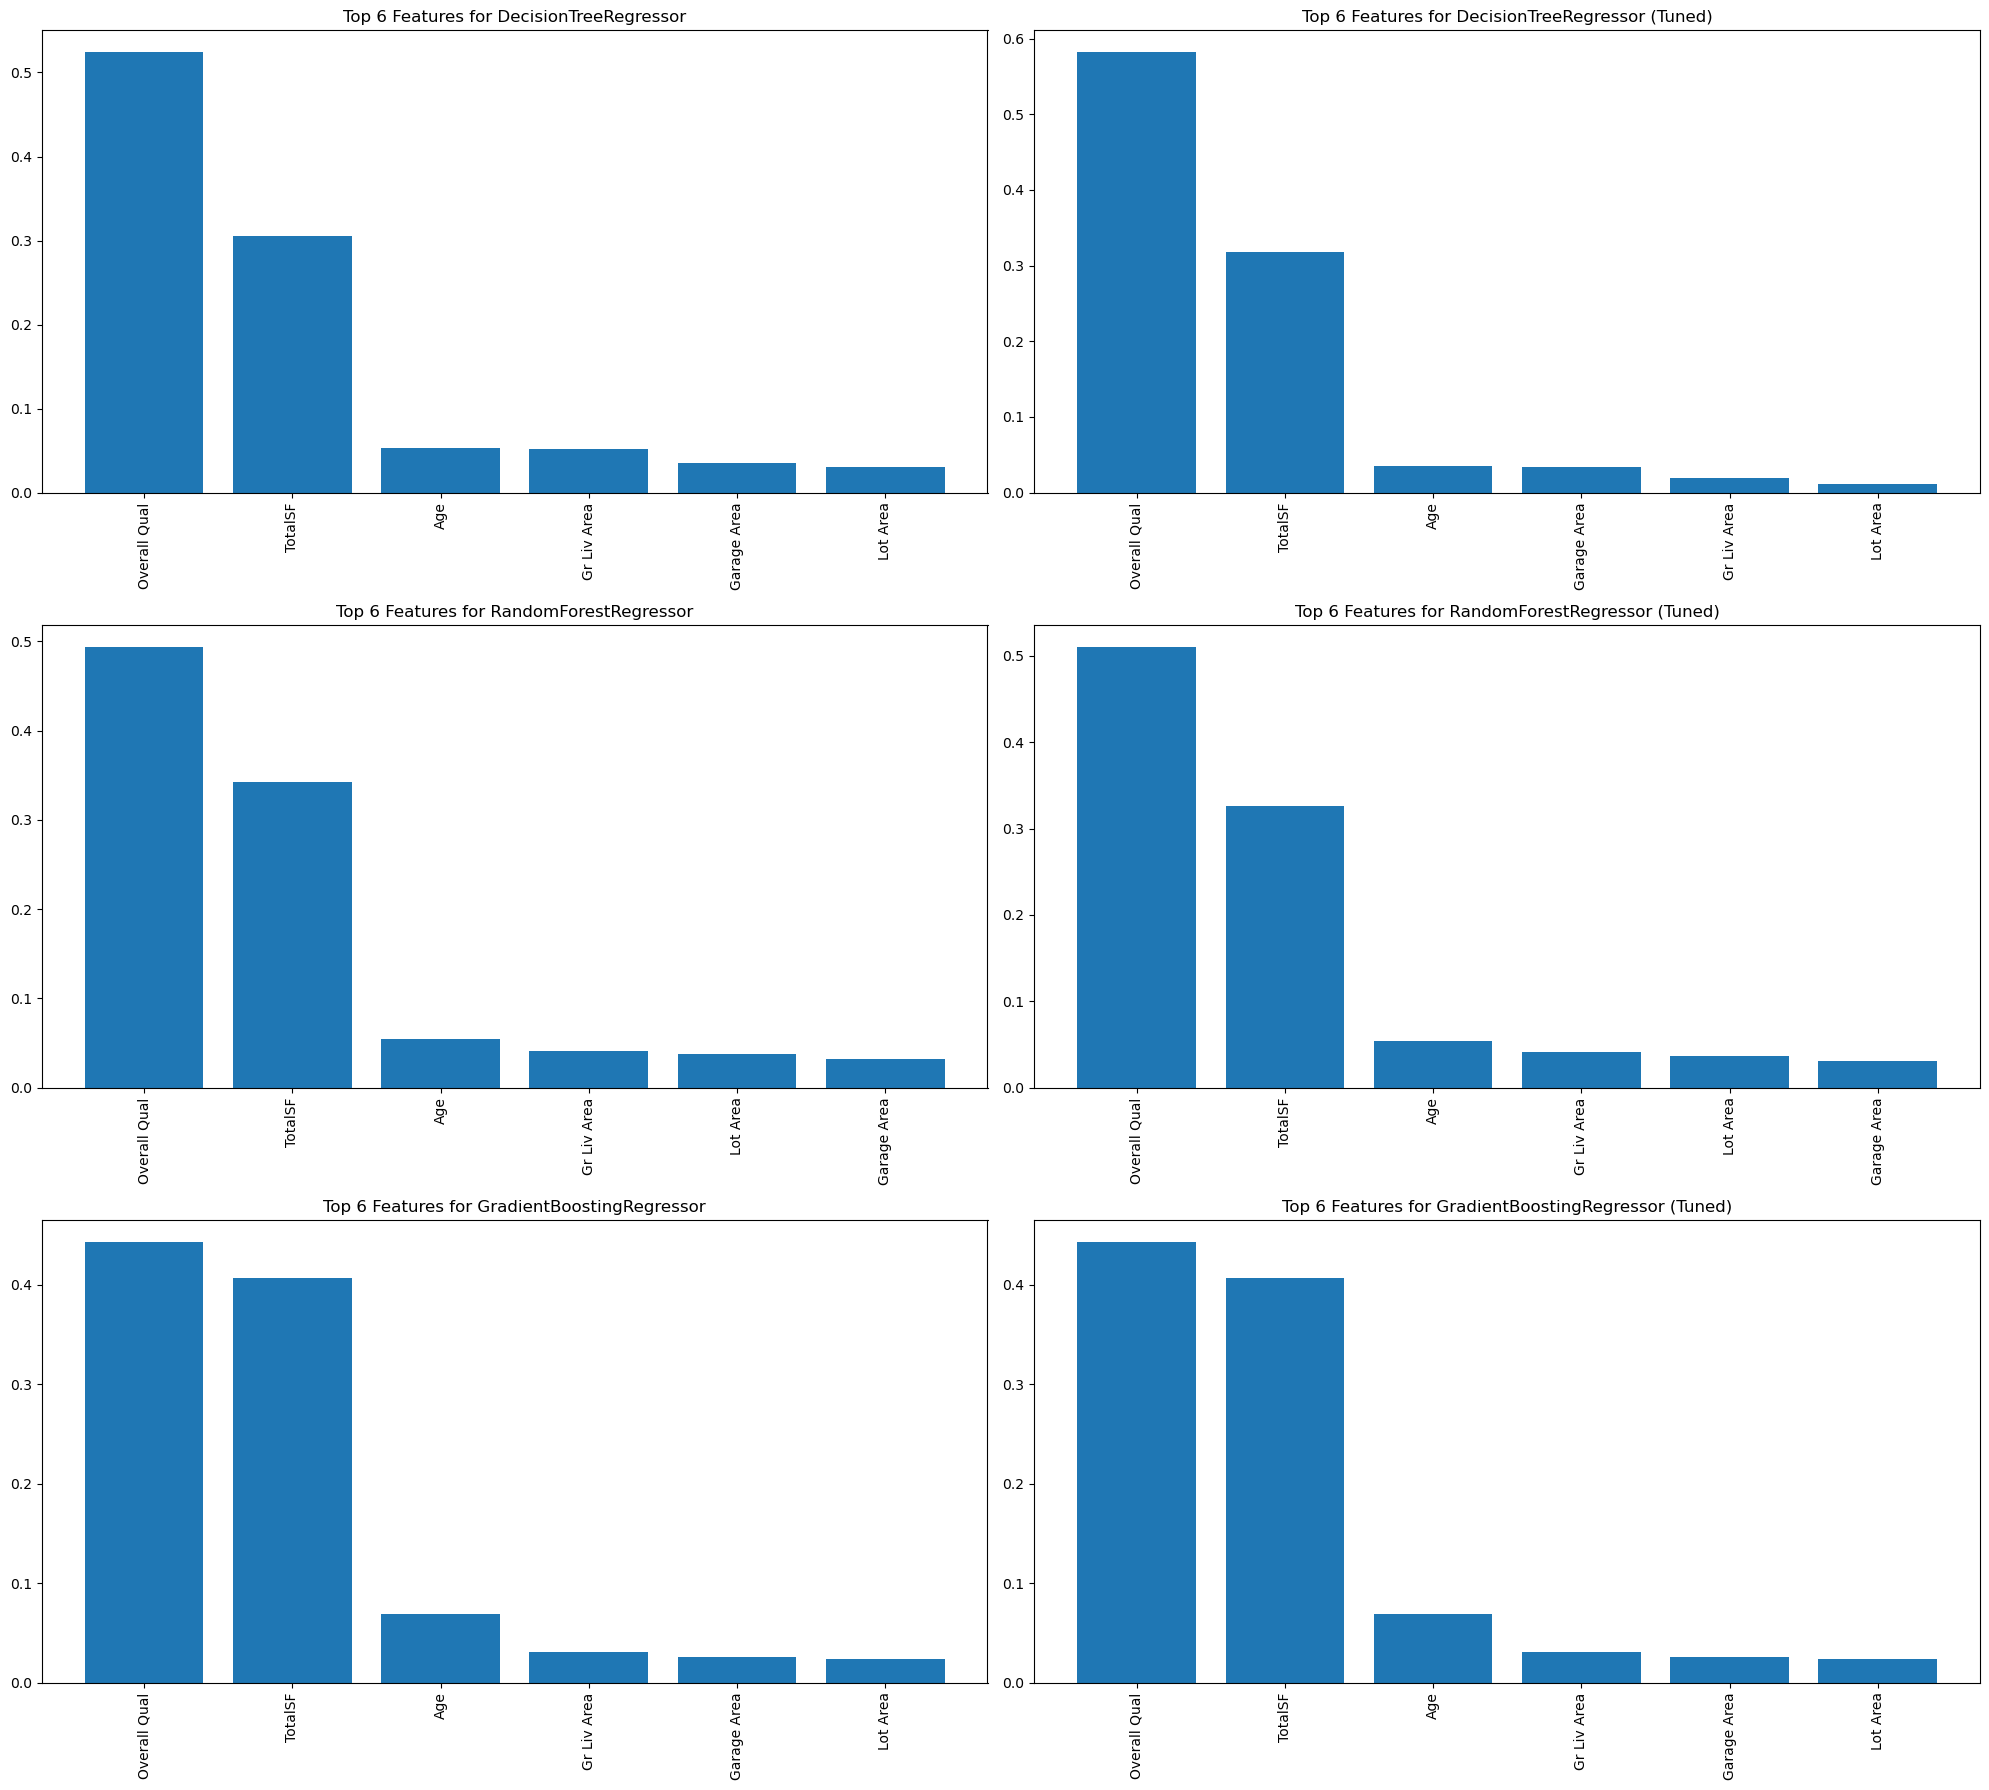

In [ ]:
# Plot the top features for each tree based model
num_models = len(results_df[results_df['Top Features'] != 'Not applicable for this model'])
rows = (num_models + 1) // 2  # Adjust rows calculation to ensure enough subplots
fig, axs = plt.subplots(rows, 2, figsize=(20, rows * 6))
axs = axs.flatten()  # Flatten the array to handle indexing
num_top_features = len(top_features)

for i, (idx, row) in enumerate(results_df[results_df['Top Features'] != 'Not applicable for this model'].iterrows()):
    top_features = row['Top Features']
    model_name = row['Model']
    ax = axs[i]
    ax.bar(range(num_top_features), [feat[0] for feat in top_features])
    ax.set_xticks(range(num_top_features))
    ax.set_xticklabels([feat[1] for feat in top_features], rotation=90)
    ax.set_title(f'Top {num_top_features} Features for {model_name}')

# Remove any empty subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
# Load zillow_api key 
import os
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("zillow_api")

# Zillo API URL
url = "https://api.bridgedataoutput.com/api/v2/zgecon/"

# Determine type
type = ""

# Store a search term
query = ""

# Build URL
query_url = f"{url}{type}access_code={api_key}&metadataType="

NameError: name 'load_dotenv' is not defined